In [1]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/corona-dataset/Corona_NLP_train.csv',encoding='ISO-8859-1')
df_test = pd.read_csv('/kaggle/input/corona-dataset/Corona_NLP_test.csv')

In [3]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [5]:
df['TweetAt'] = pd.to_datetime(df['TweetAt'])

/tmp/ipykernel_43/1259316306.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['TweetAt'] = pd.to_datetime(df['TweetAt'])


In [6]:
df.drop_duplicates(subset='OriginalTweet',inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.9+ MB


In [8]:
tweets_per_day = df['TweetAt'].dt.strftime('%m-%d').value_counts().sort_index().reset_index(name='counts')

In [9]:
tweets_per_country = df['Location'].value_counts().loc[lambda x : x > 100].reset_index(name='counts')

In [10]:
df = df[['OriginalTweet','Sentiment']]

In [11]:
df_test = df_test[['OriginalTweet','Sentiment']]

In [12]:
!pip install demoji
import demoji


# Download the demoji library's emoji dataset
demoji.download_codes()

# Clean emojis from text using the demoji library
def strip_emoji(text):
    return demoji.replace(text, '')

# Remove punctuations, links, mentions, and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()  # Remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # Remove non utf8/ascii characters
    banned_list = string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '»' + '§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))  # Remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))  # Remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

# Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) or ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+", " ", text)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.8 MB/s eta 0:00:00


/tmp/ipykernel_43/183906384.py:6: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [13]:
texts_new = []
for t in df.OriginalTweet:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


# Now, texts_new contains the cleaned tweets


In [14]:
texts_new_test = []
for t in df_test.OriginalTweet:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [15]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [16]:
df['text_clean'].head()

0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia woolworths to give elder...
3    my food stock is not the only one which is emp...
4    me ready to go at supermarket during the covid...
Name: text_clean, dtype: object

In [17]:
df_test['text_clean'].head()

0    trending new yorkers encounter empty supermark...
1    when i couldnt find hand sanitizer at fred mey...
2    find out how you can protect yourself and love...
3    panic buying hits newyork city as anxious shop...
4    toiletpaper dunnypaper coronavirus coronavirus...
Name: text_clean, dtype: object

In [18]:
df['text_clean'][1:8].values

array(['advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order',
       'coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid19 outbreak',
       'my food stock is not the only one which is empty please dont panic there will be enough food for everyone if you do not take more than you need stay calm stay safe covid19france covid19 covid19 coronavirus confinement confinementotal confinementgeneral',
       'me ready to go at supermarket during the covid19 outbreak not because im paranoid but because my food stock is litteraly empty the coronavirus is a serious thing but please dont panic it causes shortage coronavirusfrance restezchezvous stayathome confinement',
       'as news of the regions first confirmed covid19 case came out of sullivan county last week people 

In [19]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [20]:
df['text_len'] = text_len

In [21]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [22]:
df_test['text_len'] = text_len_test

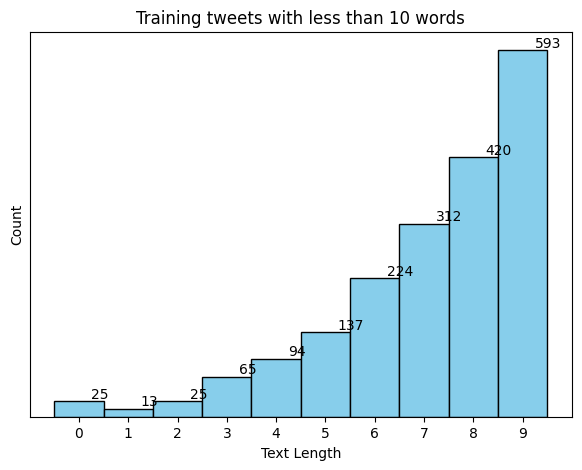

In [23]:

plt.figure(figsize=(7, 5))

# Filter the DataFrame for text lengths less than 10
filtered_df = df[df['text_len'] < 10]

# Create a histogram using Matplotlib
counts, bins, _ = plt.hist(filtered_df['text_len'], bins=range(11), color='skyblue', edgecolor='black', align='left')

# Add labels and title
plt.title('Training tweets with less than 10 words')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(bins[:-1])  # Set x-axis ticks to bin edges
plt.yticks([])

# Add count labels on top of the bars
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.25, count, str(int(count)), va='bottom')

plt.show()

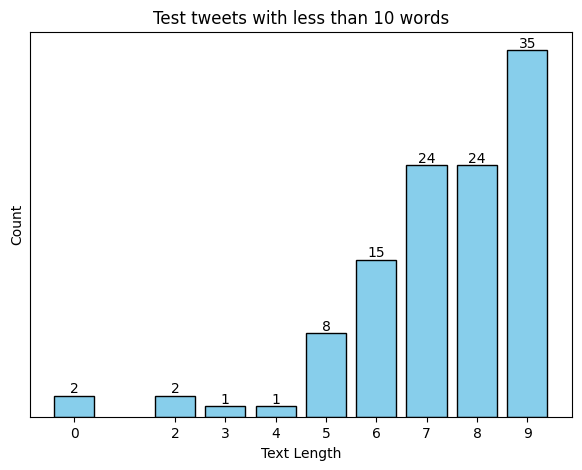

In [24]:

plt.figure(figsize=(7, 5))

# Filter the DataFrame for text lengths less than 10
filtered_df_test = df_test[df_test['text_len'] < 10]

# Create a bar plot using Matplotlib
ax = plt.bar(filtered_df_test['text_len'].value_counts().sort_index().index,
             filtered_df_test['text_len'].value_counts().sort_index(), color='skyblue', edgecolor='black')

# Add labels and title
plt.title('Test tweets with less than 10 words')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.xticks(filtered_df_test['text_len'].value_counts().sort_index().index)
plt.yticks([])

# Add count labels on top of the bars
for bar in ax:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, int(height), ha='center', va='bottom')

plt.show()

In [25]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (41157, 4)
 DF TEST SHAPE: (3798, 4)


In [26]:
df = df[df['text_len'] > 4]

In [27]:
df_test = df_test[df_test['text_len'] > 4]

In [28]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (40935, 4)
 DF TEST SHAPE: (3792, 4)


In [29]:
from transformers import DebertaTokenizer

tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [30]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [31]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 107


In [32]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 1622, TEXT: zsah policie proti spekulantm s roukami na mj popud hejtman steckho kraje ve spoluprci s podle krizovho zkona zajistil tm 700 tisrouek od firmy kter je mla dodat na zdravotnkm ale na posledn chvli se snaila navyovat cenu spolutozvladneme
INDEX: 8689, TEXT: bitte anschauen 12 emotionaler aufruf von gehard bosselmann aus hannover bitte gehen sie zu ihrem bcker um die ecke schei egal wie der heit bitte gehen sie hin bcker mittelstand handwerk landbckereibosselmann hannover emsland covid19 coronavirus
INDEX: 11155, TEXT: keine wertgegenstnde im fahrzeug lassen diesen tipp sollte man am besten immer amp nicht nur in zeiten von corona befolgen in wrselen wurde die scheibe eines pkw eingeschlagen amp mehrere rollen klopapier gestohlen
INDEX: 13623, TEXT: hoy aplaudo a mi segunda familia aplaudoanuestrosheroes aquellos con los que he compartido tantas noches de trabajo y tanta alegra s que como siempre dan todo por el bien de su comunidad presidente por ellos tambin cuarente

In [33]:
df['token_lens'] = token_lens

In [34]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
37156,11 Nisan Cumartesi itibariyle ?BBÂnin tÃ¼m hi...,Neutral,11 nisan cumartesi itibariyle bbnin tm hizmetl...,39,107
1638,ZÃ¡sah policie proti spekulant?m s rouÂkami. ...,Neutral,zsah policie proti spekulantm s roukami na mj ...,39,102
16632,Bir mÃ¼ddettir sÃ¼permarketlerin lojistik hizm...,Neutral,bir mddettir spermarketlerin lojistik hizmeti ...,36,99
13691,Hoy aplaudo a mi segunda familia #AplaudoANues...,Neutral,hoy aplaudo a mi segunda familia aplaudoanuest...,38,91
8730,?Bitte anschauen! (1/2)\r\r\n\r\r\nEmotionaler...,Negative,bitte anschauen 12 emotionaler aufruf von geha...,36,89
14593,"Na, wer war denn da am Werk? Gestern Nachmitta...",Extremely Negative,na wer war denn da am werk gestern nachmittag ...,37,86
28978,PM OF INDIA MR. NARENDREA MODI HAS TAKEN VERY ...,Negative,pm of india mr narendrea modi has taken very r...,33,86
30206,#LDA City Lahore Residential Files Prices Upda...,Neutral,lda city lahore residential files prices updat...,43,85
11213,Keine WertgegenstÃ¤nde im Fahrzeug lassen! - D...,Negative,keine wertgegenstnde im fahrzeug lassen diesen...,33,82
14582,hiked prices in the face of the Covid-19 crise...,Negative,hiked prices in the face of the covid19 crises...,47,82


In [35]:
df = df.iloc[12:]
df.head()

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
4844,Impct of #coronavirus i hve sen hw civilizd pp...,Extremely Negative,impct of coronavirus i hve sen hw civilizd ppl...,48,80
35512,Hand Sanitizer Gel type 500ml \r\r\nRM 55 \r\r...,Extremely Positive,hand sanitizer gel type 500ml rm 55 exd postag...,32,79
9238,Hi @Zomato I felt hungry loggd in ur app tryd ...,Extremely Positive,hi i felt hungry loggd in ur app tryd to add 4...,55,78
9027,La escena se repite alrededor del mundo: desde...,Neutral,la escena se repite alrededor del mundo desde ...,38,77
11106,Which global recession? V or U or L or I? For ...,Negative,which global recession v or u or l or i for no...,64,75


In [36]:
df = df.sample(frac=1).reset_index(drop=True)

In [37]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))

max_len=np.max(token_lens_test)

In [38]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 92


In [39]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 286, TEXT: so hard to decide as much as i want to hodl my 2 ccdcv4 token our place is declared to lock down due to covid19 i will use this to buy some food to stock txnid093bd1db0c0d3a62af15883138a5f57d4cef35ae14e31e602b74489dd2524c7f my b
INDEX: 345, TEXT: informoval jsem zstupce vech obchodnch etzc o aktulnch opatench vldy etzce jsou zsobovny na 95 take nen dvod panikait zsoby potravin fakt nedojdou nen opravdu dvod dnes obsadit a vykoupit supermarkety
INDEX: 2380, TEXT: ahora seguid llorando por el papel higinico que no he comprado porque an tengo seguid creando histeria y preocupacin poniendo fotos de gente en pnico y estanteras vacas que yo seguir yendo a comercios responsables de barrio donde nos cuidan hoy y siempre gracias


In [40]:
df_test['token_lens'] = token_lens_test

In [41]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
2383,Ahora seguid llorando por el papel higiénico (...,Negative,ahora seguid llorando por el papel higinico qu...,44,92
286,@Rhett800cc So hard to decide??. As much as I ...,Negative,so hard to decide as much as i want to hodl my...,38,90
345,Informoval jsem zástupce vech obchodních ?et?...,Neutral,informoval jsem zstupce vech obchodnch etzc o ...,31,89
1064,A woman waits her turn to enter the supermarke...,Neutral,a woman waits her turn to enter the supermarke...,35,73
2688,Imagine if we had a president who had a plan f...,Extremely Negative,imagine if we had a president who had a plan f...,42,73
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,73
2418,Me and my family Quarantined on February 28th ...,Positive,me and my family quarantined on february 28th ...,43,72
2918,obyrne EVAUK actionhunger may food union spark...,Extremely Negative,obyrne evauk actionhunger may food union spark...,56,72
1485,DTF-Dont Touch Face\r\r\nDWBH-Do Wash Both Ha...,Extremely Negative,dtfdont touch face dwbhdo wash both hands gtfo...,42,71
2740,COVID-19: Your government will save ITSELF not...,Positive,covid19 your government will save itself not y...,43,70


In [42]:
df_test = df_test.iloc[5:]
df_test.head(3)

,OriginalTweet,Sentiment,text_clean,text_len,token_lens
855,"Lidl is total chaos, queues as long as the ais...",Extremely Negative,lidl is total chaos queues as long as the aisl...,62,73
2418,Me and my family Quarantined on February 28th ...,Positive,me and my family quarantined on february 28th ...,43,72
2918,obyrne EVAUK actionhunger may food union spark...,Extremely Negative,obyrne evauk actionhunger may food union spark...,56,72


In [43]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [44]:
df['Sentiment'].value_counts()

Sentiment
Positive              11382
Negative               9886
Neutral                7560
Extremely Positive     6618
Extremely Negative     5477
Name: count, dtype: int64

In [45]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [46]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [47]:
df['Sentiment'].value_counts()

Sentiment
2    18000
0    15363
1     7560
Name: count, dtype: int64

In [48]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [49]:
train_os['Sentiment'].value_counts()

Sentiment
0    18000
2    18000
1    18000
Name: count, dtype: int64

In [50]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

In [51]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [52]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

In [53]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [54]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [55]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 48600
VALIDATION DATA: 5400
TESTING DATA: 3787


In [56]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [57]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [58]:
nb_clf = MultinomialNB()

In [59]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [60]:
nb_pred = nb_clf.predict(X_test_tf)

In [61]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.70      0.78      0.74      1629
     Neutral       0.59      0.43      0.50       613
    Positive       0.73      0.72      0.73      1545

    accuracy                           0.70      3787
   macro avg       0.67      0.64      0.65      3787
weighted avg       0.69      0.70      0.69      3787



In [62]:
MAX_LEN=128

In [63]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [64]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [65]:
token_lens = []

for txt in X_train:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

80

In [66]:
MAX_LEN=128

In [67]:
def tokenize_deberta(data, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [68]:
train_input_ids, train_attention_masks = tokenize_deberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_deberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_deberta(X_test, MAX_LEN)

In [69]:
MAX_LEN

128

In [70]:
def create_model(deberta_model, max_len=MAX_LEN):
    opt = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = deberta_model([input_ids,attention_masks])
    output = tf.keras.layers.GlobalAveragePooling1D()(output[0])  # Add this line
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=[accuracy])
    return model

In [71]:
from transformers import TFDebertaModel

deberta_model = TFDebertaModel.from_pretrained('microsoft/deberta-base')


tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaModel.

All the layers of TFDebertaModel were initialized from the model checkpoint at microsoft/deberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDebertaModel for predictions without further training.


In [72]:
model = create_model(deberta_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_deberta_model (TFDebert  TFBaseModelOutput(last_hid   1386017   ['input_1[0][0]',             
 aModel)                     den_state=(None, 128, 768)   28         'input_2[0][0]']             
                             , hidden_states=None, atte                                           
                             ntions=None)                                                     

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

model_checkpoint = ModelCheckpoint(
    'model.h5',
    monitor='val_loss',
    save_best_only=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=0.001
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30, callbacks=[model_checkpoint, reduce_lr, early_stopping])

Epoch 1/4
1620/1620 [==============================] - ETA: 0s - loss: 0.4819 - categorical_accuracy: 0.8201

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1620/1620 [==============================] - 1588s 946ms/step - loss: 0.4819 - categorical_accuracy: 0.8201 - val_loss: 0.2974 - val_categorical_accuracy: 0.8959 - lr: 5.0000e-05
Epoch 2/4
1620/1620 [==============================] - 1497s 924ms/step - loss: 0.2528 - categorical_accuracy: 0.9138 - val_loss: 0.2279 - val_categorical_accuracy: 0.9211 - lr: 5.0000e-05
Epoch 3/4
1620/1620 [==============================] - 1490s 920ms/step - loss: 0.1734 - categorical_accuracy: 0.9428 - val_loss: 0.2470 - val_categorical_accuracy: 0.9294 - lr: 5.0000e-05
Epoch 4/4
1620/1620 [==============================] - 1494s 922ms/step - loss: 0.1167 - categorical_accuracy: 0.9619 - val_loss: 0.2191 - val_categorical_accuracy: 0.9315 - lr: 5.0000e-05


In [74]:
result_deberta = model.predict([test_input_ids,test_attention_masks])

119/119 [==============================] - 44s 309ms/step


In [75]:
y_pred_deberta =  np.zeros_like(result_deberta)
y_pred_deberta[np.arange(len(y_pred_deberta)), result_deberta.argmax(1)] = 1

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from math import sqrt

# Calculate MSE
mse = mean_squared_error(y_test, y_pred_deberta)

# Calculate RMSE
rmse = sqrt(mse)

# Print classification report, MSE and RMSE
print('\tMean Squared Error: ', mse)
print('\tRoot Mean Squared Error: ', rmse)
print('\n')
# Calculate accuracy
accuracy = accuracy_score(y_test,y_pred_deberta)

# Print classification report and accuracy
print('\tClassification Report for DeBERTa:\n\n', classification_report(y_test, y_pred_deberta, target_names=['Negative', 'Neutral', 'Positive']))
print('\tAccuracy: ', accuracy)

	Mean Squared Error:  0.07816213361499869
	Root Mean Squared Error:  0.2795749159259441


	Classification Report for DeBERTa:

               precision    recall  f1-score   support

    Negative       0.95      0.84      0.89      1629
     Neutral       0.78      0.84      0.81       613
    Positive       0.87      0.94      0.90      1545

   micro avg       0.88      0.88      0.88      3787
   macro avg       0.86      0.87      0.87      3787
weighted avg       0.89      0.88      0.88      3787
 samples avg       0.88      0.88      0.88      3787

	Accuracy:  0.882756799577502
